In [1]:
X = [
    [1, 3, 3],
    [12, 5, 6],
    [0.4, 8, 1],

]

In [2]:
class Matrix:
    def __init__(self, matrix):
      """
      Инициализирует разреженную матрицу.

      :param matrix: Матрица списком.
      """
      self.rows = len(matrix)
      self.cols = len(matrix[0])

      self.values = []
      self.col_index = []
      self.row_pointers = [0]

      for i in range(len(matrix)):
        for j in range(len(matrix[i])):
          if matrix[i][j] != 0:
            self.values.append(matrix[i][j])
            self.col_index.append(j)
        self.row_pointers.append(len(self.values))

    def trace(self):
      """
      Вычисляет след матрицы (cумма элементов главной диагонали).

      :return: след матрицы.
      """
      trace = 0

      for row_index in range(len(self.row_pointers) - 1):
        start = self.row_pointers[row_index]
        end = self.row_pointers[row_index + 1]

        for i in range(start, end):
          if self.col_index[i] == row_index:
            trace += self.values[i]

      return trace

    def get_element(self, row, col):
      """
      Находит элемент матрицы по списку

      :param row: Индекс строки
      :param col: Индекс столбца

      :return: Значение элемента.
      """
      if row < 1 or col < 1 or row > self.rows or col > self.cols:
        raise IndexError("Индекс(-ы) выходят за пределы матрицы")

      row -= 1
      col -= 1

      start = self.row_pointers[row]
      end = self.row_pointers[row + 1]

      for i in range(start, end):
        if self.col_index[i] == col:
          return self.values[i]

      return 0

    def return_full_matrix(self):
      """
      Возвращает плотную матрицу в виде списка.

      :return: Матрица в виде списка.
      """
      print_matrix = [[0 for _ in range(self.cols)] for _ in range(self.rows)]

      for row_index in range(len(self.row_pointers) - 1):
        start = self.row_pointers[row_index]
        end = self.row_pointers[row_index + 1]

        for i in range(start, end):
          col = self.col_index[i]
          print_matrix[row_index][col] = self.values[i]

      return print_matrix

    def return_csr_matrix(self):
      """
      Возвращает матрицу разреженно-строчном виде.

      :return: Матрица в разреженно-строчном виде.
      """
      return self.values, self.col_index, self.row_pointers

    def determinant(self) -> float:
      """
      Вычисляет определитель матрицы (рекурсивно по минорам).
      """
      if self.rows != self.cols:
        raise ValueError("Невозможно найти определитель для неквадратной матрицы")

      if self.rows == 1:
        return self.values[0] if self.values else 0.0
      if self.rows == 2:
        a = self.get_element(1, 1)
        b = self.get_element(1, 2)
        c = self.get_element(2, 1)
        d = self.get_element(2, 2)
        return a * d - b * c

      det = 0.0
      full = self.return_full_matrix()
      start, end = self.row_pointers[0], self.row_pointers[1]

      for idx in range(start, end):
        col = self.col_index[idx]
        val = self.values[idx]

        minor_dense = []
        for row in full[1:]:
          minor_dense.append([row[j] for j in range(self.cols) if j != col])

        minor = self.__class__(minor_dense)

        sign = -1 if (col % 2) else 1

        det += val * sign * minor.determinant()

      return det

    def multiply(self, other: 'Matrix') -> 'Matrix':
      """
      A(i×p) · B(p×m) → C(i×m) в CSR формате, чистый проход по строкам A и
      соответствующим строкам B (CSR у B позволяет быстро брать строки).
      """
      if self.cols != other.rows:
          raise ValueError("Число столбцов A != числу строк B")

      result = Matrix.__new__(Matrix)
      result.rows, result.cols = self.rows, other.cols
      result.values, result.col_index, result.row_pointers = [], [], [0]

      for i in range(self.rows):
          row_acc = {}
          # проходим по ненулевым в A[i,*]
          for idx1 in range(self.row_pointers[i], self.row_pointers[i+1]):
              j  = self.col_index[idx1]   # кол-во столбцов A == кол-во строк B
              v1 = self.values[idx1]
              # обходим строку j матрицы B
              for idx2 in range(other.row_pointers[j], other.row_pointers[j+1]):
                  k  = other.col_index[idx2]
                  v2 = other.values[idx2]
                  row_acc[k] = row_acc.get(k, 0.0) + v1 * v2
          # заполняем результат i‑й строкой
          for col in sorted(row_acc):
              result.col_index.append(col)
              result.values.append(row_acc[col])
          result.row_pointers.append(len(result.values))

      return result

    def T(self) -> 'Matrix':
      """
      Возвращает транспонированную матрицу
      """
      values, col_index, row_ptrs = [], [], [0]

      for col in range(self.cols):
          for row in range(self.rows):
              val = self.get_element(row + 1, col + 1)
              if val != 0:
                  values.append(val)
                  col_index.append(row)
          row_ptrs.append(len(values))

      trans = Matrix.__new__(Matrix)
      trans.rows, trans.cols = self.cols, self.rows
      trans.values, trans.col_index, trans.row_pointers = (values, col_index, row_ptrs)
      return trans

    def minus_lambda_I(self, lam: float) -> 'Matrix':
      """Возвращает матрицу (A − λI)."""
      full = self.return_full_matrix()
      for i in range(self.rows):
          full[i][i] -= lam
      return Matrix(full)


In [3]:
def calculate_means(data):
    """Вычисление средних значений для каждого признака"""
    return [sum(col)/len(col) for col in zip(*data)]

def dot_product(v1, v2) -> float:
    return sum(x*y for x, y in zip(v1, v2))

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]



In [4]:
import typing
from typing import List, Tuple

1.1


гаус


In [5]:
from typing import List

def gauss_solver(A: List[List[float]], b: List[float]) -> List[List[float]]:
    """
    Вход:
    A: матрица коэффициентов (n×n). Используется класс Matrix из предыдущей
    лабораторной работы,→
    b: вектор правых частей (n×1)
    Выход:
    list[Matrix]: список базисных векторов решения системы
    Raises:
    ValueError: если система несовместна
    """
    eps = 1e-12
    n = len(A)

    # расширенная м-ца
    augmented = [row[:] + [b[i]] for i, row in enumerate(A)]

    pivot_cols = []
    current_row = 0

    # гаусом проходим
    for col in range(n):
        # находим макс знач
        pivot_row = None
        max_val = 0.0
        for row in range(current_row, n):
            if abs(augmented[row][col]) > max_val:
                max_val = abs(augmented[row][col])
                pivot_row = row

        # скип если маленькое число
        if pivot_row is None or max_val < eps:
            continue

        # свапаем если хотим
        if pivot_row != current_row:
            augmented[current_row], augmented[pivot_row] = augmented[pivot_row], augmented[current_row]

        # нормисуем
        pivot = augmented[current_row][col]
        for j in range(col, n + 1):
            augmented[current_row][j] /= pivot

        # удаляем из других строк
        for row in range(n):
            if row != current_row:
                factor = augmented[row][col]
                if abs(factor) > eps:
                    for j in range(col, n + 1):
                        augmented[row][j] -= factor * augmented[current_row][j]

        pivot_cols.append(col)
        current_row += 1
        if current_row == n:
            break

    # совместна или не
    for row in range(current_row, n):
        if abs(augmented[row][n]) > eps:
            raise ValueError("Система несовместна")

    # свободные переменные
    free_cols = [col for col in range(n) if col not in pivot_cols]

    # частное решение
    xp = [0.0] * n
    for i, col in enumerate(pivot_cols):
        xp[col] = augmented[i][n]

    # базис (A*x = 0)
    null_basis = []
    for free in free_cols:
        vec = [0.0] * n
        vec[free] = 1.0

        # находим значения завис перм
        for i, pivot in enumerate(pivot_cols):
            vec[pivot] = -augmented[i][free]

        null_basis.append(vec)

    return [xp] + null_basis, free_cols


#   2x + y = 5
#   x - y = 1
A1 = [
    [2, 1],
    [1, -1]
]
b1 = [5, 1]
sol1 = gauss_solver(A1, b1)
print("пупипам")
for sol in sol1:
    print(sol)


пупипам
[[2.0, 1.0]]
[]


1.2


In [6]:
import math
from typing import List, Tuple

def center_data(X: List[List[float]]) -> List[List[float]]:
    """
    Вход: матрица данных X (n×m)
    Выход: центрированная матрица X_centered (n×m)
    """
    if not X or not X[0]:
        return X

    n_samples = len(X)
    n_features = len(X[0])

    # находим среднее по каждому
    means = [0.0] * n_features
    for row in X:
        for j in range(n_features):
            means[j] += row[j]
    means = [m / n_samples for m in means]

    # центрируем
    X_centered = []
    for row in X:
        centered_row = [row[j] - means[j] for j in range(n_features)]
        X_centered.append(centered_row)

    return X_centered, means



1.3

In [7]:
from typing import List

def covariance_matrix(X_centered: List[List[float]]) -> List[List[float]]:
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    n = len(X_centered)
    if n < 2:
        raise ValueError("мало")

    if not X_centered:
        return []

    m = len(X_centered[0])

    #проверка, что все строки одинаковой длины
    if any(len(row) != m for row in X_centered):
        raise ValueError("одинаковая длина")

    #инициализация матрицы ковариаций
    C = [[0.0 for _ in range(m)] for _ in range(m)]

    #вычисляем сумму произведений для каждой пары признаков
    for i in range(m):
        for j in range(i, m):
            cov = sum(X_centered[k][i] * X_centered[k][j] for k in range(n)) / (n - 1)
            C[i][j] = cov
            if i != j:
                C[j][i] = cov

    return C

2.1

In [8]:
from typing import List

def find_eigenvalues(C: List[List[float]], tol: float = 1e-6, max_iter: int = 100) -> List[float]:
    """
    Вход:
    C: матрица ковариаций (m×m)
    tol: допустимая погрешность
    Выход: список вещественных собственных значений
    """
    m = len(C)
    if m != len(C[0]):
        raise ValueError("Матрица должна быть квадратной")

    # 1. Оценка диапазона λ (круги Гершгорина)
    lo, hi = float('inf'), -float('inf')
    for i in range(m):
        center = C[i][i]
        radius = sum(abs(C[i][j]) for j in range(m) if j != i)
        lo = min(lo, center - radius)
        hi = max(hi, center + radius)

    # Если все λ одинаковы (вырожденный случай)
    if abs(hi - lo) < tol:
        return [C[0][0]] * m



    # 3. Поиск интервалов смены знака det(C - λI)
    def f(lam: float) -> float:
        C_shifted = [row.copy() for row in C]
        for i in range(m):
            C_shifted[i][i] -= lam
            C_shiftedd = Matrix(C_shifted)
        return C_shiftedd.determinant()

    # Грубая сетка для поиска интервалов
    q = m * 4
    step = (hi - lo) / q
    intervals = []
    a = lo
    fa = f(a)
    for _ in range(q):
        b = a + step
        fb = f(b)
        if abs(fa) < tol:
            intervals.append((a, a))
        elif abs(fb) < tol:
            intervals.append((b, b))
        elif fa * fb < 0:
            intervals.append((a, b))
        a, fa = b, fb

    # 4. Уточнение корней бисекцией
    roots = []
    for a, b in intervals:
        if a == b:
            roots.append(a)
            continue
        fa = f(a)
        for _ in range(max_iter):
            mid = (a + b) / 2
            fmid = f(mid)
            if abs(fmid) < tol:
                roots.append(mid)
                break
            if fa * fmid < 0:
                b = mid
            else:
                a, fa = mid, fmid
        else:
            roots.append((a + b) / 2)

    # 5. Если корней меньше m, добавляем дубликаты
    while len(roots) < m:
        roots.append(roots[-1] if roots else 0.0)

    return sorted(roots, reverse=True)




2.2

In [9]:
def find_eigenvectors(C: List[List[float]],
                     eigenvalues: List[float],
                     tol: float = 1e-6) -> List[List[float]]:
    """
    Вход:
    C: матрица ковариаций (m×m)
    eigenvalues: список собственных значений
    Выход: список собственных векторов (каждый вектор - объект Matrix)
    """
    m = len(C)
    eigenvectors = []

    for lambda_ in eigenvalues:
        # матрица (C - λI)
        A = [[C[i][j] - (lambda_ if i == j else 0.0) for j in range(m)] for i in range(m)]

        # к ступенчатому
        rank = 0
        for col in range(m):
            # макс эл
            pivot_row = max(range(rank, m), key=lambda r: abs(A[r][col]), default=-1)
            if pivot_row == -1 or abs(A[pivot_row][col]) < tol:
                continue

            A[rank], A[pivot_row] = A[pivot_row], A[rank]

            # нормируем
            pivot_val = A[rank][col]
            A[rank] = [x/pivot_val for x in A[rank]]

            # исключаем из друг
            for row in range(m):
                if row != rank and abs(A[row][col]) > tol:
                    factor = A[row][col]
                    A[row] = [A[row][j] - factor * A[rank][j] for j in range(m)]
            rank += 1

        # Находим свободные переменные
        pivot_cols = []
        for row in range(rank):
            for col in range(m):
                if abs(A[row][col]) > tol:
                    pivot_cols.append(col)
                    break

        free_cols = [col for col in range(m) if col not in pivot_cols]

        if not free_cols:
            # Если не нашли свободных переменных, используем метод обратных итераций
            eigenvector = [1.0 if i == 0 else 0.0 for i in range(m)]  # Вектор по умолчанию
        else:
            # Строим собственный вектор
            eigenvector = [0.0]*m
            eigenvector[free_cols[0]] = 1.0
            for row in reversed(range(rank)):
                col = pivot_cols[row]
                eigenvector[col] = -sum(A[row][j]*eigenvector[j] for j in range(col+1, m))

            # Нормализация
            norm = math.sqrt(sum(x**2 for x in eigenvector))
            if norm > tol:
                eigenvector = [x/norm for x in eigenvector]

        eigenvectors.append(eigenvector)

    return eigenvectors

2.3


In [10]:
from typing import List

def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вход:
    eigenvalues: список собственных значений
    k: число компонент
    Выход: доля объяснённой дисперсии
    """
    # Отфильтровываем отрицательные значения (возникают из-за численных погрешностей)
    eigenvalues = [max(0, eig) for eig in eigenvalues]

    total_variance = sum(eigenvalues)

    if total_variance <= 0:
        return 0.0

    # Сортируем по убыванию и берем первые k компонент
    sorted_eig = sorted(eigenvalues, reverse=True)[:k]

    return sum(sorted_eig) / total_variance

In [11]:
def dot(A: List[List[float]], B: List[List[float]]) -> List[List[float]]:
    """
    Умножение матриц A (n×m) и B (m×p) → результат (n×p)
    """
    n = len(A)
    m = len(A[0]) if n > 0 else 0
    p = len(B[0]) if len(B) > 0 else 0

    # Проверка совместимости размеров
    if len(B) != m:
        raise ValueError(f"Несовместимые размеры матриц: A {n}x{m} и B {len(B)}x{p}")

    # Инициализация результирующей матрицы
    result = [[0.0 for _ in range(p)] for _ in range(n)]

    for i in range(n):
        for j in range(p):
            for k in range(m):
                result[i][j] += A[i][k] * B[k][j]

    return result

In [12]:
from typing import List, Tuple

def sort_eigen(eigenvalues: List[float],
               eigenvectors: List[List[float]]) -> Tuple[List[float], List[List[float]]]:
    """
    Сортирует собственные значения и соответствующие им векторы по убыванию значений.

    """
    # Проверка согласованности входных данных
    if len(eigenvalues) != len(eigenvectors):
        raise ValueError("Количество собственных значений должно совпадать с количеством векторов")

    if not eigenvectors:
        return [], []

    vector_len = len(eigenvectors[0])
    for vec in eigenvectors:
        if len(vec) != vector_len:
            raise ValueError("Все собственные векторы должны иметь одинаковую длину")

    # Создаем список кортежей (значение, вектор) для совместной сортировки
    paired = list(zip(eigenvalues, eigenvectors))

    # Сортируем по убыванию собственных значений
    paired.sort(reverse=True, key=lambda x: x[0])

    # Разделяем обратно на значения и векторы
    sorted_values, sorted_vectors = zip(*paired)

    # Преобразуем векторы к списку списков (на случай если на входе были другие последовательности)
    sorted_vectors = [list(vec) for vec in sorted_vectors]

    return list(sorted_values), sorted_vectors

3.1

In [14]:
def pca(X: List[List[float]], k: int) -> Tuple[List[List[float]], List[List[float]], List[float], float]:
    """
    Вход:
    X: матрица данных (n×m)
    k: число главных компонент
    Выход:
    X_proj: проекция данных (n×k)
    : доля объяснённой дисперсии
    """
    # 1. Центрирование данных
    X_centered, means = center_data(X)

    # 2. Ковариационная матрица
    cov_mat = covariance_matrix(X_centered)

    # 3. Собственные значения и векторы
    eigenvalues = find_eigenvalues(cov_mat)
    eigenvectors = find_eigenvectors(cov_mat, eigenvalues=eigenvalues)

    # 4. Сортировка по убыванию собственных значений
    sorted_indices = sorted(range(len(eigenvalues)), key=lambda i: -eigenvalues[i])
    eigenvalues_sorted = [eigenvalues[i] for i in sorted_indices]
    eigenvectors_sorted = [eigenvectors[i] for i in sorted_indices]

    # 5. Выбор первых k компонент
    principal_components = eigenvectors_sorted[:k]

    # 6. Проекция данных
    X_proj = [
        [dot_product(row, comp) for comp in principal_components]
        for row in X_centered
    ]

    # 7. Доля объясненной дисперсии
    total_variance = sum(eigenvalues_sorted)
    var_ratio = sum(eigenvalues_sorted[:k]) / total_variance

    return X_proj, principal_components, var_ratio, means

3.2

In [15]:
# Загрузка данных
from sklearn.datasets import load_iris
iris = load_iris()
data = [list(map(float, row)) for row in iris.data]

In [16]:
pca(X, k=2)

([[-3.1581859928660134, 2.756663666041233],
  [7.99023350504693, -0.3598636799081363],
  [-4.832047512180918, -2.396799986133098]],
 [[0.9343925502682959, -0.08418289881781073, 0.346155747532437],
  [-0.187067145339209, -0.94287838487209, 0.2756560075087032]],
 1.0000000000445946,
 [4.466666666666667, 5.333333333333333, 3.3333333333333335])

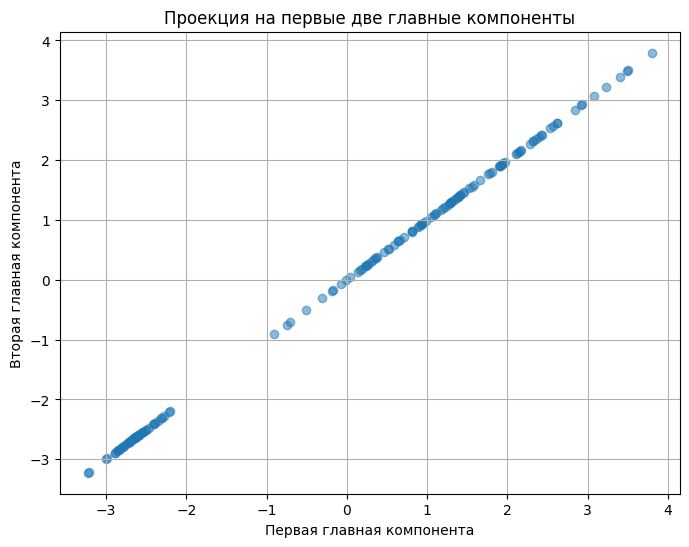

In [17]:
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: List[List[float]]):
    """
    Вход: проекция данных X_proj (n×2)
    Выход: объект Figure из Matplotlib
    """

    if len(X_proj[0]) < 2:
        raise ValueError("Матрица проекций должна содержать как минимум 2 столбца")

    plt.figure(figsize=(8, 6))
    x = [row[0] for row in X_proj]
    y = [row[1] for row in X_proj]

    plt.scatter(x, y, alpha=0.5)
    plt.title('Проекция на первые две главные компоненты')
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.grid(True)
    plt.show()  # Явный вызов show()
proj = pca(data, k = 2)[0]
plot_pca_projection(proj)


3.3

In [18]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
  """
  Вход:
  X_orig: исходные данные (n×m)
  X_recon: восстановленные данные (n×m)
  Выход: среднеквадратическая ошибка MSE
  """
  # Проверка размеров матриц
  if len(X_orig) != len(X_recon):
      raise ValueError("Матрицы должны иметь одинаковое количество строк")

  n = len(X_orig)
  if n == 0:
      return 0.0

  m = len(X_orig[0])
  total = 0.0
  count = 0

  for i in range(n):
      # Проверка количества столбцов в каждой строке
      if len(X_orig[i]) != len(X_recon[i]):
          raise ValueError("Строки матриц должны иметь одинаковую длину")

      for j in range(m):
          diff = X_orig[i][j] - X_recon[i][j]
          total += diff * diff
          count += 1

  # Вычисление среднего значения
  if count == 0:
      return 0.0

  mse = total / count
  return mse
rec = pca(X, k = 3)[1]
reconstruction_error(X, rec)


32.51352283037746

4.1

In [19]:
def auto_select_k(eigenvalues, threshold=0.85):
    """
    Вход:
    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """
    # Проверка входных данных


    # Сумма всех собственных значений
    total_variance = sum(eigenvalues)
    # Накапливаем объяснённую дисперсию
    explained_variance = 0.0
    k = 0

    for i, ev in enumerate(sorted(eigenvalues, reverse=True)):
        explained_variance += ev / total_variance
        if explained_variance >= threshold:
            k = i + 1
            break

    return k

eug = find_eigenvalues(X)
auto_select_k(eug)

3

4.2

In [20]:
def handle_missing_values(X: 'Matrix') -> 'Matrix':
  """
  Вход: матрица данных X (n×m) с возможными NaN
  Выход: матрица данных X_filled (n×m) без NaN
  """
  if not X or not X[0]:
      raise ValueError("Матрица данных не может быть пустой")

  n_rows = len(X)
  n_cols = len(X[0])

  # Проверка согласованности размеров
  for row in X:
      if len(row) != n_cols:
          raise ValueError("Все строки матрицы должны иметь одинаковую длину")

  # Вычисляем средние по столбцам
  column_means = []
  for j in range(n_cols):
      sum_val = 0.0
      count = 0
      for i in range(n_rows):
          val = X[i][j]
          if val is not None and not (isinstance(val, float) and val != val):  # Проверка на NaN
              sum_val += val
              count += 1

      if count == 0:
          raise ValueError(f"Все значения в столбце {j} пропущены")

      column_means.append(sum_val / count)

  # Заполняем пропущенные значения
  X_filled = []
  for i in range(n_rows):
      filled_row = []
      for j in range(n_cols):
          val = X[i][j]
          if val is None or (isinstance(val, float) and val != val):  # Проверка на None или NaN
              filled_row.append(column_means[j])
          else:
              filled_row.append(val)
      X_filled.append(filled_row)

  return X_filled

X_bad = [
    [1, None, 3],
    [None, None, 2],
    [3, 2, 1]
    ]

handle_missing_values(X_bad)


[[1, 2.0, 3], [2.0, 2.0, 2], [3, 2, 1]]

4.3

In [21]:
import random
import math
import random
import math
from typing import List, Dict, Any


def add_noise_and_compare(X: List[List[float]], noise_level: float = 0.1) -> Dict[str, Any]:
    """
    Сравнивает PCA до и после добавления шума

    Параметры:
        X: матрица данных (n×m)
        noise_level: уровень шума (доля от стандартного отклонения)

    Возвращает:
        Словарь с результатами сравнения PCA
    """
    # 1. Проверка и подготовка входных данных
    if not X or not isinstance(X[0], list):
        raise ValueError("Некорректный формат входных данных")

    n, m = len(X), len(X[0])

    # 2. Вычисление статистик с обработкой None
    valid_data = [[x for x in row if x is not None] for row in zip(*X)]
    means = [sum(col)/len(col) if col else 0.0 for col in valid_data]
    stds = [
        math.sqrt(sum((x - mean)**2 for x in col)/len(col)) if col else 0.0
        for col, mean in zip(valid_data, means)
    ]

    # 3. PCA для исходных данных
    orig_proj, orig_recon, orig_var, means = pca(X, k=min(3, m))

    # Получаем собственные значения из проекций
    orig_eigvals = [sum(x**2 for x in col)/n for col in zip(*orig_proj)]

    # 4. Генерация зашумленных данных
    noisy_data = [
        [
            x + random.gauss(0, noise_level*stds[j]) if x is not None else means[j]
            for j, x in enumerate(row)
        ]
        for row in X
    ]

    # 5. PCA для зашумленных данных
    noisy_proj, noisy_recon, noisy_var, meanss = pca(noisy_data, k=min(3, m))
    noisy_eigvals = [sum(x**2 for x in col)/n for col in zip(*noisy_proj)]

    # 6. Сравнение результатов
    min_len = min(len(orig_eigvals), len(noisy_eigvals))
    eigval_diff = [
        abs(orig - noisy)
        for orig, noisy in zip(orig_eigvals[:min_len], noisy_eigvals[:min_len])
    ]

    # 7. Формирование результата
    return {
        'орига': {
            'eigenvalues': orig_eigvals[:3],
            'explained_variance': orig_var
        },
        'нойз мси': {
            'eigenvalues': noisy_eigvals[:3],
            'explained_variance': noisy_var
        },
        'разница': {
            'eigenvalues_diff': eigval_diff,
            'variance_loss': orig_var - noisy_var
        }
    }
print(add_noise_and_compare(X))

{'орига': {'eigenvalues': [32.38888446356115, 4.491115536438845, 6.935067551548482e-20], 'explained_variance': 1.0}, 'нойз мси': {'eigenvalues': [29.953797471816305, 3.9574621958680525, 7.627625004060814e-23], 'explained_variance': 1.0}, 'разница': {'eigenvalues_diff': [2.4350869917448428, 0.5336533405707926, 6.92743992654442e-20], 'variance_loss': 0.0}}


4.4

In [22]:
from sklearn.datasets import load_iris

# Загрузка датасета Iris
iris = load_iris()
data = iris.data.tolist()  # Конвертируем numpy array в list of lists
target = iris.target.tolist()

print("Размерность данных:", len(data), "x", len(data[0]))
print("Первые 3 строки:")
for row in data[:3]:
    print(row)

Размерность данных: 150 x 4
Первые 3 строки:
[5.1, 3.5, 1.4, 0.2]
[4.9, 3.0, 1.4, 0.2]
[4.7, 3.2, 1.3, 0.2]


In [23]:
from typing import List, Tuple
from sklearn.datasets import load_iris
import random
import math



def reconstruct(X_pca: List[List[float]], components: List[List[float]], means: List[float]) -> List[List[float]]:
    """Корректное восстановление данных"""
    n_samples = len(X_pca)
    n_features = len(means)
    k = len(components)

    reconstructed = []
    for i in range(n_samples):
        row = [0.0]*n_features
        for j in range(n_features):
            row[j] = means[j]
            for comp_idx in range(k):
                row[j] += X_pca[i][comp_idx] * components[comp_idx][j]
        reconstructed.append(row)
    return reconstructed

def mse(original: List[List[float]], reconstructed: List[List[float]]) -> float:
    """Вычисление MSE"""
    total = 0.0
    count = 0
    for i in range(len(original)):
        for j in range(len(original[0])):
            total += (original[i][j] - reconstructed[i][j])**2
            count += 1
    return total / count

def total_variance(data: List[List[float]]) -> float:
    """Общая дисперсия данных"""
    means = calculate_means(data)
    centered = [[x - mean for x, mean in zip(row, means)] for row in data]
    return sum(x**2 for row in centered for x in row)/(len(data)-1)

# Загрузка данных
iris = load_iris()
data = [list(map(float, row)) for row in iris.data]

# Применение PCA
k = 2
X_pca, components, vrt, means = pca(data, k)

# Восстановление данных
X_reconstructed = reconstruct(X_pca, components, means)

# Оценка качества
reconstruction_mse = mse(data, X_reconstructed)
total_var = total_variance(data)
explained_variance = 1 - reconstruction_mse/total_var

print("Первые 5 восстановленных образцов:")
for row in X_reconstructed[:5]:
    print([round(x, 4) for x in row])

print(f"\nMSE восстановления: {reconstruction_mse:.4f}")
print(f"Общая дисперсия: {total_var:.4f}")
print(f"Объясненная дисперсия: {explained_variance:.2%}")

Первые 5 восстановленных образцов:
[3.9033, 3.5111, -0.8408, -0.7241]
[3.8816, 3.5161, -0.8923, -0.7456]
[3.7552, 3.5457, -1.1918, -0.8709]
[3.8591, 3.5214, -0.9457, -0.7679]
[3.8711, 3.5186, -0.9172, -0.756]

MSE восстановления: 1.1356
Общая дисперсия: 4.5730
Объясненная дисперсия: 75.17%


In [13]:
def test_sort_eigen():
    # 1. Базовый тест
    eigenvalues = [3.0, 1.0, 2.0]
    eigenvectors = [
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    sorted_values, sorted_vectors = sort_eigen(eigenvalues, eigenvectors)
    assert sorted_values == [3.0, 2.0, 1.0], f"Expected sorted eigenvalues: [3.0, 2.0, 1.0], got {sorted_values}"
    assert sorted_vectors == [[1, 0], [1, 1], [0, 1]], f"Expected sorted eigenvectors: [[1, 0], [1, 1], [0, 1]], got {sorted_vectors}"

    # 2. Тест с отрицательными значениями
    eigenvalues = [-1.0, -2.0, 3.0]
    eigenvectors = [
        [1, 2],
        [2, 1],
        [0, 1]
    ]
    sorted_values, sorted_vectors = sort_eigen(eigenvalues, eigenvectors)
    assert sorted_values == [3.0, -1.0, -2.0], f"Expected sorted eigenvalues: [3.0, -1.0, -2.0], got {sorted_values}"
    assert sorted_vectors == [[0, 1], [1, 2], [2, 1]], f"Expected sorted eigenvectors: [[0, 1], [1, 2], [2, 1]], got {sorted_vectors}"

    # 3. Тест с равными собственными значениями
    eigenvalues = [1.0, 1.0, 1.0]
    eigenvectors = [
        [1, 2],
        [2, 1],
        [0, 1]
    ]
    sorted_values, sorted_vectors = sort_eigen(eigenvalues, eigenvectors)
    assert sorted_values == [1.0, 1.0, 1.0], f"Expected sorted eigenvalues: [1.0, 1.0, 1.0], got {sorted_values}"
    assert sorted_vectors == [[1, 2], [2, 1], [0, 1]], f"Expected sorted eigenvectors: [[1, 2], [2, 1], [0, 1]], got {sorted_vectors}"

    # 4. Тест с различными размерами векторов
    try:
        eigenvalues = [3.0, 2.0]
        eigenvectors = [
            [1, 2],
            [2]
        ]
        sort_eigen(eigenvalues, eigenvectors)
        assert False, "Expected ValueError due to different vector lengths"
    except ValueError as e:
        assert str(e) == "Все собственные векторы должны иметь одинаковую длину", f"Unexpected error message: {e}"

    # 5. Тест с несовпадающим количеством значений и векторов
    try:
        eigenvalues = [3.0, 2.0]
        eigenvectors = [
            [1, 2]
        ]
        sort_eigen(eigenvalues, eigenvectors)
        assert False, "Expected ValueError due to mismatched eigenvalues and eigenvectors count"
    except ValueError as e:
        assert str(e) == "Количество собственных значений должно совпадать с количеством векторов", f"Unexpected error message: {e}"

    print("Все тесты прошли успешно!")

# Запуск тестов
test_sort_eigen()


Все тесты прошли успешно!
